In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import seaborn as sns

In [3]:
df = pd.read_parquet("../data/processed/cleaned_df.parquet")
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,6532F46EF12DCA8C,electric_bike,2025-06-12 15:08:06.700000+00:00,2025-06-12 15:11:20.652000+00:00,Mercer St & Bleecker St,5679.05,E 1 St & Bowery,5636.13,40.727064,-73.996621,40.724861,-73.992131,member
1,DE5D64BE54489439,electric_bike,2025-06-12 13:05:20.309000+00:00,2025-06-12 13:22:18.812000+00:00,45 Rd & 11 St,6319.01,43 Ave & 42 St,6251.06,40.747086,-73.949772,40.745347,-73.921942,member
2,A19F721536473DA2,classic_bike,2025-06-13 18:03:51.268000+00:00,2025-06-13 18:11:24.704000+00:00,95 St & 35 Ave,6465.04,84 St & Roosevelt Ave,6323.04,40.753010,-73.872660,40.747970,-73.882040,member
3,5695831104F572BB,classic_bike,2025-06-11 17:01:40.807000+00:00,2025-06-11 17:24:19.780000+00:00,4 Ave & 17 St,3739.06,Willoughby St & Ashland Pl,4587.02,40.665507,-73.993037,40.691780,-73.978770,member
4,08F1301EED21DFC7,electric_bike,2025-06-06 18:43:26.907000+00:00,2025-06-06 18:48:48.209000+00:00,Mercer St & Bleecker St,5679.05,St Marks Pl & 2 Ave,5669.10,40.727064,-73.996621,40.728419,-73.987140,member


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9084898 entries, 0 to 9084897
Data columns (total 13 columns):
 #   Column              Dtype              
---  ------              -----              
 0   ride_id             string             
 1   rideable_type       category           
 2   started_at          datetime64[ns, UTC]
 3   ended_at            datetime64[ns, UTC]
 4   start_station_name  string             
 5   start_station_id    string             
 6   end_station_name    string             
 7   end_station_id      string             
 8   start_lat           float64            
 9   start_lng           float64            
 10  end_lat             float64            
 11  end_lng             float64            
 12  member_casual       category           
dtypes: category(2), datetime64[ns, UTC](2), float64(4), string(5)
memory usage: 779.8 MB


In [22]:
df["trip_duration_min"] = (df["ended_at"] - df["started_at"]).dt.total_seconds() / 60

## Sampling Data

Due to computational constraints and diminishing analytical returns from very large samples, a stratified random sample was used.

The sample preserves the original distribution of rideable type and user type while remaining statistically robust.

In [23]:
target_n = 500_000

df_sampled = (
    df.groupby(["rideable_type", "member_casual"], group_keys=False)
    .apply(lambda x: x.sample(
        n=int(len(x) / len(df) * target_n),
        random_state=42
    ))
)

/var/folders/r3/fhz0cy092rq1vdp607ycp5zc0000gn/T/ipykernel_22252/2876045948.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["rideable_type", "member_casual"], group_keys=False)
/var/folders/r3/fhz0cy092rq1vdp607ycp5zc0000gn/T/ipykernel_22252/2876045948.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(["rideable_type", "member_casual"], group_keys=False)


## Question:
Does using electric bikes change rider behavior compared to classic bikes, and does this effect differ between members and casual users?

Metric: Median Trip Duration

Control group (A): Classic Bikes

Treatment group (B): Electric Bikes

One ride = one observation

All rides are in a fixed time window: May and June of 2025

H0 (null): there's no signficant difference in trip duration between electric and classic bikes
H1 (alt): electric bikes have a different trip duration than classic bikes

## Exploration

In [ ]:
analysis = df.groupby(["rideable_type", "member_casual"])["trip_duration_min"].describe()

/var/folders/r3/fhz0cy092rq1vdp607ycp5zc0000gn/T/ipykernel_22252/2421593136.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analysis = df.groupby(["rideable_type", "member_casual"])["trip_duration_min"].describe()


count       mean        std       min  \
rideable_type member_casual                                              
classic_bike  casual          457924.0  26.498028  89.493560  1.000550   
              member         2238651.0  11.785847  35.178054  1.000267   
electric_bike casual         1335579.0  19.438884  34.211869  1.000467   
              member         5052744.0  11.543800  10.343207  0.277683   

                                  25%        50%        75%         max  
rideable_type member_casual                                              
classic_bike  casual         9.145400  15.712267  26.448375  14629.4085  
              member         4.343092   7.681167  13.814933   1499.9759  
electric_bike casual         7.453133  12.515067  21.445650   1499.9404  
              member         5.254133   8.801950  14.715633   1499.8058

## Visualization

In [ ]:
duration_constraint_df = df[(df["trip_duration_min"] >= 1) & (df["trip_duration_min"] <= 120)]
classic = duration_constraint_df[duration_constraint_df["rideable_type"] == "classic_bike"]["trip_duration_min"]
electric = duration_constraint_df[duration_constraint_df["rideable_type"] == "electric_bike"]["trip_duration_min"]

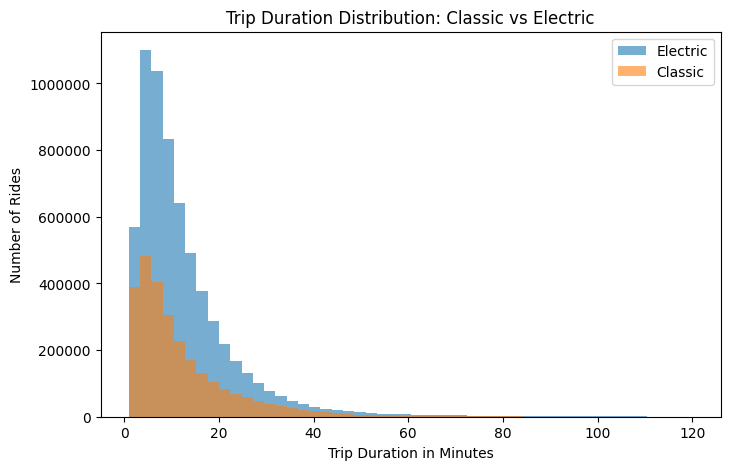

In [30]:
plt.figure(figsize=(8,5))
plt.hist(electric, bins=50, alpha=0.6, label="Electric")
plt.hist(classic, bins=50, alpha=0.6, label="Classic")
plt.legend()
plt.ticklabel_format(style="plain")
plt.xlabel("Trip Duration in Minutes")
plt.ylabel("Number of Rides")
plt.title("Trip Duration Distribution: Classic vs Electric")
plt.show()

Trip duration is heavily right-skewed and has a long right tail I avoid parametric test and use a Mann-Whitney U test.

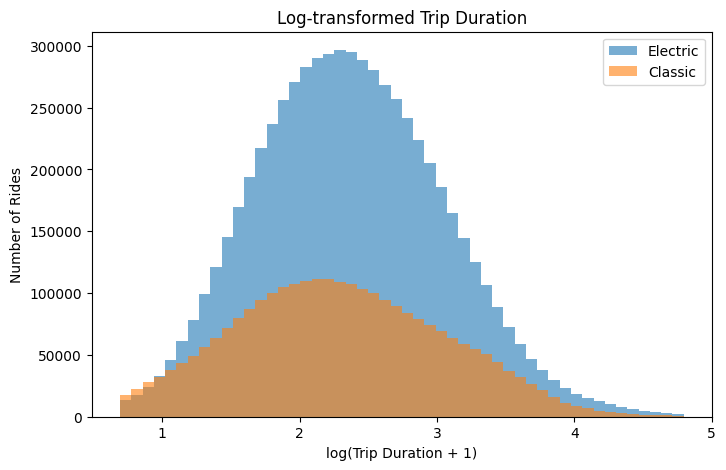

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(np.log1p(electric), bins=50, alpha=0.6, label="Electric")
plt.hist(np.log1p(classic), bins=50, alpha=0.6, label="Classic")
plt.legend()
plt.xlabel("log(Trip Duration + 1)")
plt.ylabel("Number of Rides")
plt.title("Log-transformed Trip Duration")
plt.show()

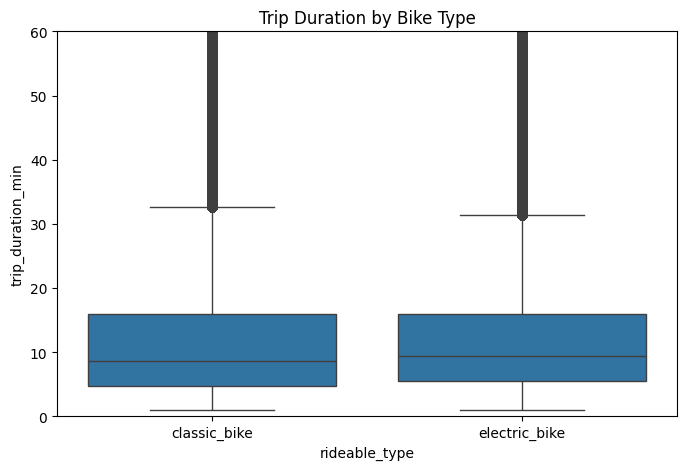

In [35]:
plt.figure(figsize=(8,5))
sns.boxplot(data=duration_constraint_df,
            x="rideable_type",
            y="trip_duration_min"
)
plt.ylim(0,60)
plt.title("Trip Duration by Bike Type")
plt.show()

## Testing

In [66]:
electric_sample = df_sampled[df_sampled["rideable_type"]=="electric_bike"].dropna()["trip_duration_min"]
classic_sample = df_sampled[df_sampled["rideable_type"]=="classic_bike"].dropna()["trip_duration_min"]

In [70]:
stat, p_value = mannwhitneyu(
    classic_sample,
    electric_sample,
    alternative="two-sided"
)

print(f"Mann-Whitney U test p-value: {p_value}")

Mann-Whitney U test p-value: 9.197425019476253e-234


The probability that the observed difference in trip duration between classic and electric bikes happened by random chance is essentially zero.

However, due to the large sample size, I focus on median differences to assess practical impact than statistical significance alone.

In [75]:
classic_median = classic.median()
electric_median = electric.median()

diff = electric_median - classic_median
pct_diff = diff / classic_median * 100

print(f"Classic median: {classic_median:.2f} min")
print(f"Electric median: {electric_median:.2f} min")
print(f"Difference: {diff:.2f} min ({pct_diff:.1f}%)")

Classic median: 8.62 min
Electric median: 9.44 min
Difference: 0.81 min (9.4%)


While the statistical test shows an extremely significant difference, the practical effect size is moderate. Electric bikes increase median trip duration by approximately 9%, suggesting they enable slightly longer trips without fundamentally changing usage patterns.

Now I look if there's a difference between casual users and members behavior when it comes to a bike type.

In [76]:
median_type = df.groupby(["rideable_type", "member_casual"])["trip_duration_min"].median()
median_type

/var/folders/r3/fhz0cy092rq1vdp607ycp5zc0000gn/T/ipykernel_22252/1761660559.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_type = df.groupby(["rideable_type", "member_casual"])["trip_duration_min"].median()


rideable_type  member_casual
classic_bike   casual           15.537417
               member            7.669867
electric_bike  casual           12.406283
               member            8.798450
Name: trip_duration_min, dtype: float64

For casual riders median ride duration with a classic bike is 15.54 mins and with an electric bike is 12.41 mins, which means electric rides are ~20% shorter.
For members median ride duration with a classic bike is 7.67 mins and with an electric bike is 8.80 min, which makes electric rides ~15% longer.

Casual:
- Likely tourists / leisure users
- Electric bikes are faster, less effort
- Finish trips more efficiently
-> Shorter rides are expected

Members:
- Likely commuters
- Electric bikes make longer commutes feasible
-> Longer rides are expected

Electric bikes reduce trip duration for casual riders but increase trip duration for members.

**Evidence**

Casual median ↓ ~20%
Member median ↑ ~15%
Mann–Whitney U test p ≈ 0

**Interpretation**

Electric bikes enable members to extend commuting range while helping casual users complete trips faster.

Product Recommendations:
1. Pricing
- Casuals: promote electric bikes for sightseeing efficiency
- Members: position electric bikes as commute extenders

2. Ops
- Longer dock occupation by members
- Higher battery turnover in commute-heavy areas